<a href="https://colab.research.google.com/github/josesg998/Calculadora_fechas_vencimiento/blob/main/image_processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import kagglehub
import os
import polars as pl
import matplotlib.pyplot as plt
from PIL import Image
import shutil
import numpy as np
from concurrent.futures import ThreadPoolExecutor

from torchvision import transforms, datasets

from torch.utils.data import DataLoader, Dataset
from torch.utils.data.dataset import random_split
from torch import no_grad, max, zeros, device, optim, nn, Generator, stack, long
import torch
import torch.nn.functional as F

In [2]:
# Download latest version
path = kagglehub.dataset_download("ahmedxc4/parasite-dataset")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/ahmedxc4/parasite-dataset/versions/1


In [3]:
#movemos las tres carpetas a content
ruta_origen = path
# ruta main de colab
ruta_destino = '/content'

try:
  shutil.move(os.path.join(ruta_origen, 'parasite-dataset'), os.path.join(ruta_destino, 'parasite-dataset'))
except:
  print("Ya se movió la carpeta a /content")

Ya se movió la carpeta a /content


In [4]:
folders = os.listdir('parasite-dataset')
folders.remove('README.md')

def process_image(ruta_completa):
    try:
        imagen = Image.open(ruta_completa)
        ancho, alto = imagen.size
        return ancho, alto
    except OSError:
        return None

def measure_means_folder():
    metricas = {}
    for folder in folders:
        print(folder)
        metricas[folder] = {}

        # Inicializar variables para calcular la media del tamaño de las imágenes
        total_imagenes = 0
        suma_ancho = 0
        suma_alto = 0

        # Inicializar variable para contar imágenes en distintos rangos de tamaño
        rangos_tamano = {
            '0-100x0-100': 0,
            '101-200x101-200': 0,
            '201-300x201-300': 0,
            '301-infx301-inf': 0
        }

        directorio = os.path.join('parasite-dataset', folder)
        archivos = [os.path.join(directorio, archivo) for archivo in os.listdir(directorio) if archivo.endswith(('.png', '.jpg', '.jpeg'))]

        with ThreadPoolExecutor() as executor:
            results = executor.map(process_image, archivos)

        for result in results:
            if result:
                ancho, alto = result
                total_imagenes += 1
                suma_ancho += ancho
                suma_alto += alto

                if ancho <= 100 and alto <= 100:
                    rangos_tamano['0-100x0-100'] += 1
                elif ancho <= 200 and alto <= 200:
                    rangos_tamano['101-200x101-200'] += 1
                elif ancho <= 300 and alto <= 300:
                    rangos_tamano['201-300x201-300'] += 1
                else:
                    rangos_tamano['301-infx301-inf'] += 1

        # Calculate means and store in metricas
        if total_imagenes > 0:
            metricas[folder]['mean_width'] = suma_ancho / total_imagenes
            metricas[folder]['mean_height'] = suma_alto / total_imagenes
            metricas[folder]['total_images'] = total_imagenes

            for rango, cantidad in rangos_tamano.items():
                metricas[folder][rango] = cantidad

    return metricas

In [5]:
#metricas = measure_means_folder()

In [6]:
#metricas_df = pl.DataFrame()
#for key in metricas.keys():
#    row_df = pl.DataFrame(metricas[key])
#    row_df = row_df.with_columns(folder=pl.lit(key))
#    # put folder column in the first position
#    row_df = row_df.select(['folder','total_images' ,'mean_width', 'mean_height', '0-100x0-100', '101-200x101-200', '201-300x201-300', '301-infx301-inf'])
#    #split size_ranges into separate columns
#    metricas_df = metricas_df.vstack(row_df)

#metricas_df = metricas_df.sort('total_images', descending=False)
#metricas_df

In [7]:
# plot the counts as horizontal barchart with plt
#plt.figure(figsize=(10, 5))
#plt.barh(metricas_df['folder'], metricas_df['total_images'])
#plt.title('Conteo de imágenes por carpeta')
#plt.xlabel('conteo')
#plt.ylabel('especie')
#plt.show()

In [8]:
def train_test_val(folder='parasite-dataset'):
  # Define the transformations for the dataset
  transform_first = transforms.Compose([
        transforms.Resize((32, 32))
        ,transforms.ToTensor()
    ])

     # Create the dataset object
  dataset = datasets.ImageFolder(root=folder,transform=transform_first)

  # Define the split ratio (e.g., 80% train, 20% test)
  train_ratio = 0.8
  test_ratio = 1 - train_ratio

  # Calculate the number of samples for each split
  train_size = int(len(dataset) * train_ratio)
  test_size = len(dataset) - train_size

  # Split the dataset into train and test sets
  train_dataset, test_dataset = random_split(dataset, [train_size, test_size], generator=Generator().manual_seed(42))

  # Calculate the number of samples for each split
  #train_size = int(len(train_dataset) * train_ratio)
  #val_size = len(train_dataset) - train_size

  # Split the dataset into train and test sets
  #train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size], generator=Generator().manual_seed(42))

  print(f"Train dataset size: {len(train_dataset)}")
  print(f"Test dataset size: {len(test_dataset)}")
  #print(f"Validation dataset size: {len(val_dataset)}")

  return train_dataset, test_dataset#, val_dataset

In [9]:
train_dataset, test_dataset = train_test_val()

# Calcular media y desviación estándar de los tres canales (train dataset)
labels = 2

imgs = stack([img_t for img_t, label in train_dataset if (label<labels)], dim=3)
mean = imgs.view(3, -1).mean(dim=1)
std = imgs.view(3, -1).std(dim=1)


print(f'Media: {mean}')
print(f'Desviación estándar: {std}')

Train dataset size: 27438
Test dataset size: 6860
Media: tensor([0.5874, 0.5264, 0.6187])
Desviación estándar: tensor([0.1053, 0.1092, 0.0921])


In [10]:
#train_dataset, test_dataset = train_test_val(tensor=False)

In [11]:
from torch import tensor, long

In [12]:
class TrainDataset(Dataset):

  def __init__(self, partition, mean, std,n_classes):
    '''
    Constructor de la clase. Podemos pasarle todos los parámetros que querramos,
    en este caso usamos:
    - partition: si es 'training' o 'validation'
    - mean: la media que vamos a usar para normalizar los datos
    - std: el desvío estándar
    '''

    # usamos siempre el constructor de la clase madre primero, por las dudas que
    # inicialice cosas que nosotros no sepamos
    super(TrainDataset, self).__init__()

    # hacemos un chequeo de que no entre cualquier cosa en vez de partition
    assert partition in ['training', 'validation'], 'partition has to be training or validation, not {}'.format(partition)

    # armamos las transformaciones que tenemos que aplicarle a los datos,
    # incluyendo la normalización

    if partition =='training':

      # Define the transformations for the dataset
      transform_train = transforms.Compose([
          transforms.Resize((32, 32)),
          # Definir las transformaciones de aumento
          #transforms.RandomRotation(40),
          #transforms.RandomAffine(degrees=0, shear=0.2),
          #transforms.RandomResizedCrop(size=(224, 224), scale=(0.8, 1.2)),
          #transforms.RandomHorizontalFlip(),
          #transforms.ColorJitter(brightness=(0.5, 1.5)),
          transforms.ToTensor()
          ,transforms.Normalize(mean=mean, std=std)
      ])

      dataset_f = train_dataset

      dataset_f.transform = transform_train

    else:
      # Define the transformations for the dataset
      transform_val = transforms.Compose([
          transforms.Resize((32, 32)),
          transforms.ToTensor()
          ,transforms.Normalize(mean=mean, std=std)
      ])

      #dataset_f = val_dataset
      dataset_f = test_dataset
      dataset_f.transform = transform_val


    labels = [n for n in range(n_classes)]

    # hacemos una lista de nombres para las clases
    self.class_names = dataset_f.dataset.classes[:n_classes]

    self.data = [(img,label) for img,label in dataset_f if label in labels]

  def __len__(self):
    '''
    Método que te devuelve la cantidad de elementos del dataset
    '''
    # simplemente devolvemos la longitud de la lista
    return len(self.data)


  def __getitem__(self, index):
    '''
    Método que te devuelve el elemento index del dataset
    '''
    # obtenemos la imagen y su etiqueta asociada
    img, label = self.data[index]
    # convertimos la etiqueta en un tensor de tipo long
    tensor_label = torch.zeros(1)
    tensor_label[0] = label
    label = tensor_label.long()
    # retornamos el par
    return (img, label)

In [13]:
from torch import nn
class ParasiteFullyConnectedNN(nn.Module):
  '''
  Clase que implementa una arquitectura fully connected de 2 capas para
  resolver el problema de clasificar aviones y pájaros
  '''

  def __init__(self):
    '''
    Constructor: crea la arquitectura
    '''

    # siempre llamamos al constructor de la clase madre primero
    super(ParasiteFullyConnectedNN, self).__init__()
    # número de salidas del modelo (probabilidades de ser avión o pájaro)
    n_out = 2

    self.model = nn.Sequential(
        # una capa fully connected
        nn.Linear(3072, # cantidad de features en la entrada: 32 x 32 x 3 colores
                  512),  # tamaño de la hidden layer
        # una función de activación (la tangente hiperbólica)
        nn.Tanh(),
        # otra capa fully connected
        nn.Linear(512, # tamaño de la hidden layer
                  n_out), # cantidad de clases en la salida,
        # la función de activación para las salidas, que las hace probabilidades
        nn.Softmax(dim=1)
    )

      # agregamos la función de activación como un atributo
    self.final_activation = nn.Softmax(dim=1)

  def forward(self, inputs):
    '''
    Método que implementa el forward pass
    '''
    return self.model(inputs)

  def predict(self, inputs):
    '''
    Método que usaremos de aquí en más cuando queremos predecir resultados
    '''
    # devolvemos el resultado de llamar al modelo y aplicarle la función de activación
    return self.final_activation(self.model(inputs))

In [14]:
32*32*3

3072

In [15]:
labels = 2
# creamos una instancia de nuestro training set
training_set = TrainDataset('training', mean, std,n_classes=labels)
# creamos un dataloader para los datos de training
training_loader = DataLoader(training_set, batch_size=64, shuffle=True)

# creamos una instancia de nuestro validation set
validation_set = TrainDataset('validation', mean, std,n_classes=labels)
# creamos un dataloader para los datos de validation
validation_loader = DataLoader(validation_set, batch_size=64, shuffle=False)

In [16]:
# inicializamos la función de pérdida
loss_fn = nn.CrossEntropyLoss()
# creamos una nueva instancia de la red
fc_model = ParasiteFullyConnectedNN()

In [17]:
i = 0
# recorremos por 2 iteraciones nuestro dataset de entrenamiento
for imgs, labels in training_loader:
  # imprimiendo el tamaño del batch de imágenes y el de etiquetas
  print('Image batch size: {}'.format(imgs.shape))
  print('Labels batch size: {}'.format(labels.shape))
  print('')
  i=i+1
  if i==2:
    break

Image batch size: torch.Size([64, 3, 32, 32])
Labels batch size: torch.Size([64, 1])

Image batch size: torch.Size([64, 3, 32, 32])
Labels batch size: torch.Size([64, 1])



In [18]:
# elijan si quieren usarla o no, para ver la diferencia de performance!
use_gpu = True
# elegimos si usamos cuda o cpu
if use_gpu:
  device = torch.device('cuda')
else:
  device = torch.device('cpu')


# creamos una instancia del modelo
fc_model = ParasiteFullyConnectedNN()

# creamos la loss function
loss_fn = nn.CrossEntropyLoss()

# movemos todo lo que haga falta al dispositivo que hayamos elegido
fc_model = fc_model.to(device)
loss_fn = loss_fn.to(device)

# inicializamos un valor de learning rate
learning_rate = 1e-2
# creamos una instancia de un optimizador (por ejemplo, SGD),
# pasándole los parámetros de nuestro modelo y la learning rate que queremos usar
optimizer = optim.SGD(fc_model.parameters(), lr=learning_rate)

# determinamos el número de épocas por el que queremos entrenar
n_epochs = 100

# -----------------
# TRAINING LOOP
# -----------------

# inicializamos listas para guardar los valores de loss function de entrenamiento
# y validación, además del accuracy sobre datos de validación
per_epoch_training_loss_values = np.zeros(n_epochs)
per_epoch_validation_loss_values = np.zeros(n_epochs)
per_epoch_validation_accuracy_values = np.zeros(n_epochs)

# iteramos tantas épocas como hayamos dicho
for epoch in range(n_epochs):

  # ENTRENAMIENTO
  # tenemos que poner el modelo en modo entrenamiento
  fc_model.train()

  # inicializamos una lista para ir guardando los valores de loss por batch
  training_loss_values = np.zeros(len(training_loader))

  # iteramos por cada batch
  i=0
  for imgs, labels in training_loader:

    # acomodamos las imágenes al formato de entrada de la red
    batch_size = imgs.shape[0]
    imgs = imgs.view(batch_size, -1)
    # pasamos imágenes y labels al dispositivo donde estemos corriendo
    imgs = imgs.to(device)
    labels = labels.view(-1).to(device)
    # obtenemos la respuesta del modelo
    outputs = fc_model(imgs)
    # calculamos la loss
    loss = loss_fn(outputs, labels)

    # mandamos a 0 los gradientes
    optimizer.zero_grad()
    # hacemos un backward pass
    loss.backward()
    # y un paso del optimizador para actualizar los parámetros
    optimizer.step()

    # registramos el valor de la loss
    training_loss_values[i]=float(loss.cpu())
    i=i+1

  # VALIDACIÓN
  # tenemos que poner el modelo en modo evaluación
  fc_model.eval()

  # inicializamos una lista para guardar los valores de loss por batch en los
  # datos de validación
  validation_loss_values = np.zeros(len(validation_loader))
  # y dos variables para medir la cantidad de muestras totales y la cantidad de
  # aciertos
  total = 0
  correct = 0

  # no vamos a calcular gradientes
  with no_grad():

      # iteramos por cada batch
      i=0
      for imgs, labels in validation_loader:

        # acomodamos las imágenes al formato de entrada de la red
        batch_size = imgs.shape[0]
        imgs = imgs.view(batch_size, -1)
        # pasamos imágenes y labels al dispositivo donde estemos corriendo
        imgs = imgs.to(device)
        labels = labels.view(-1).to(device)
        # obtenemos la respuesta del modelo
        outputs = fc_model(imgs)
        # calculamos la loss
        loss = loss_fn(outputs, labels)
        # registramos el valor de la loss
        validation_loss_values[i]=float(loss.cpu())
        i=i+1

        # le aplicamos la activation function a las salidas para obtener scores
        probs = fc_model.final_activation(outputs)
        # obtenemos la predicción de la clase
        _, predicted = max(probs.cpu(), dim=1)
        labels = labels.cpu()
        total += labels.shape[0]
        correct += int((predicted == labels).sum())

  # TERMINÓ LA ÉPOCA

  # actualizamos las estadísticas
  per_epoch_training_loss_values[epoch] = np.mean(training_loss_values)
  per_epoch_validation_loss_values[epoch] = np.mean(validation_loss_values)
  per_epoch_validation_accuracy_values[epoch] = correct / total

  if (epoch % 1) == 0:
    print('Epoch: {}'.format(epoch+1))
    print('- Training loss: {:.4f}'.format(per_epoch_training_loss_values[epoch]))
    print('- Validation loss: {:.4f}'.format(per_epoch_validation_loss_values[epoch]))
    print('- Validation accuracy: {:.4f}'.format(per_epoch_validation_accuracy_values[epoch]))


Epoch: 1
- Training loss: 0.6262
- Validation loss: 0.5968
- Validation accuracy: 0.7212
Epoch: 2
- Training loss: 0.6197
- Validation loss: 0.5935
- Validation accuracy: 0.7212
Epoch: 3
- Training loss: 0.6152
- Validation loss: 0.5974
- Validation accuracy: 0.7212
Epoch: 4
- Training loss: 0.6008
- Validation loss: 0.5763
- Validation accuracy: 0.7212
Epoch: 5
- Training loss: 0.5861
- Validation loss: 0.5665
- Validation accuracy: 0.7212
Epoch: 6
- Training loss: 0.5707
- Validation loss: 0.5539
- Validation accuracy: 0.8365
Epoch: 7
- Training loss: 0.5489
- Validation loss: 0.5232
- Validation accuracy: 0.8048
Epoch: 8
- Training loss: 0.5235
- Validation loss: 0.5007
- Validation accuracy: 0.8733
Epoch: 9
- Training loss: 0.5001
- Validation loss: 0.4846
- Validation accuracy: 0.8238
Epoch: 10
- Training loss: 0.4789
- Validation loss: 0.4608
- Validation accuracy: 0.9493
Epoch: 11
- Training loss: 0.4582
- Validation loss: 0.4481
- Validation accuracy: 0.8872
Epoch: 12
- Trainin

In [19]:
#transform_test = transforms.Compose([
#    transforms.Resize((224, 224)),
#    transforms.ToTensor()
#   ,transforms.Normalize(mean=mean, std=std)

#])

#train_dataset.transform = transform_train
#test_dataset.transform = transform_test

# Cargar datasets en DataLoaders
#train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
#test_loader  = DataLoader(test_dataset, batch_size=64, shuffle=False)

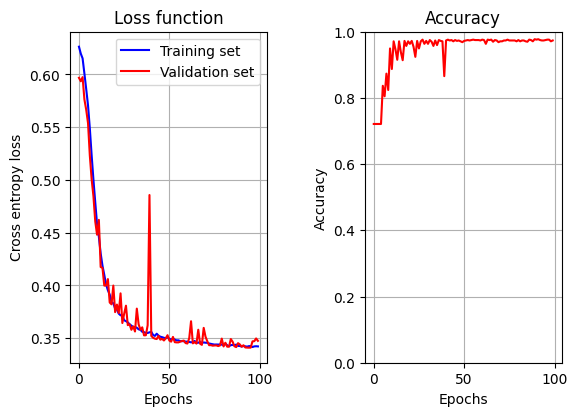

In [20]:
# creamos plots para la loss y el accuracy
fig, axes = plt.subplots(1, 2)
# graficamos la evolución de la loss de entrenamiento y la de validación
axes[0].plot(per_epoch_training_loss_values, color='blue')
axes[0].plot(per_epoch_validation_loss_values, color='red')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Cross entropy loss')
axes[0].grid(True)
axes[0].legend(['Training set', 'Validation set'])
axes[0].set_title('Loss function')
# graficamos la evolución del accuracy
axes[1].plot(per_epoch_validation_accuracy_values, color='red')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Accuracy')
axes[1].grid(True)
axes[1].set_title('Accuracy')
axes[1].set_ylim([0, 1.0])
fig.tight_layout(pad=3.0)

In [21]:
# inicializamos el tamaño de batch
batch_size = 64

# ponemos el modelo en modo evaluación
fc_model.eval()

# creamos una instancia de nuestro test set
cifar_test_set = TrainDataset('validation', mean, std,n_classes=2)
# creamos un dataloader para los datos de test
test_loader = DataLoader(cifar_test_set, batch_size=batch_size, shuffle=False)

# inicializamos matrices y arreglos para guardar:
# - probabilidades
probabilities = np.zeros((len(cifar_test_set), 2))
# - predicciones
predictions = np.zeros(len(cifar_test_set))
# - labels
labels = np.zeros(len(cifar_test_set))

# sin calcular el gradiente...
with no_grad():

  # inicializamos un contador de muestras
  num_samples = 0
  # iteramos por cada batch de test
  for i, (imgs, lbl) in enumerate(test_loader):

    # acomodamos las imágenes al formato de entrada de la red
    num_outputs = imgs.shape[0]
    imgs = imgs.view(num_outputs, -1)
    # actualizamos la cantidad de muestras que vamos llevando
    num_samples = num_samples + num_outputs

    # obtenemos las predicciones
    probs = fc_model.predict(imgs.cuda())
    # pasamos la salida a CPU
    probs = probs.cpu()
    # y recuperamos la clase más probable
    _, predicted = max(probs, dim=1)

    # colocamos las probabilidades, predicciones y etiquetas en los arreglos
    probabilities[i*batch_size : i*batch_size+num_outputs, :] = probs.numpy()
    predictions[i*batch_size : i*batch_size+num_outputs] = predicted.numpy()
    labels[i*batch_size : i*batch_size+num_outputs] = lbl.view(-1)

print("Cantidad de muestras procesadas = ", num_samples)
print("Probabilidades = ", probabilities.shape)
print("Predicciones = ", predictions.shape)
print("Etiquetas = ", labels.shape)

Cantidad de muestras procesadas =  789
Probabilidades =  (789, 2)
Predicciones =  (789,)
Etiquetas =  (789,)


In [22]:
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(labels, predictions)
print("Confusion matrix:")
print(conf_mat)

Confusion matrix:
[[209  11]
 [ 10 559]]


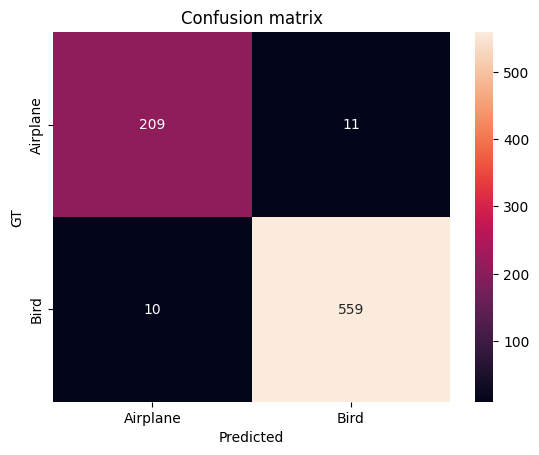

In [23]:
# importamos pandas
import pandas as pd
# y seaborn
import seaborn as sn

# generamos un dataframe de dos columnas con las etiquetas en la columna GT
# y las predicciones en la columna Predicted
df = pd.DataFrame({'GT': labels, 'Predicted': predictions}, columns=['GT','Predicted'])
# obtenemos la matriz de confusión
conf_mat = pd.crosstab(df['GT'], df['Predicted'], rownames=['GT'], colnames=['Predicted'], margins = False)
# la representamos graficamente con Seaborn
ax = plt.axes()
sn.heatmap(conf_mat, ax=ax, annot=True, fmt="d")
ax.set_title("Confusion matrix")
ax.set_xticklabels(["Airplane", "Bird"])
ax.set_yticklabels(["Airplane", "Bird"])
plt.show()